 # Library declaration 

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime
from time import process_time 
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Data Load

In [2]:
# load all data
df = pd.read_csv('./cases_timeseries_hr.csv', sep=',', header=0, low_memory=False  )
df.columns

Index(['province', 'health_region', 'date_report', 'cases',
       'cumulative_cases'],
      dtype='object')

In [3]:
 df['day']=df['date_report'].str.slice(0, 2)

In [4]:
  df['month'] = df['date_report'].str.slice(3, 5)

In [5]:
  df['year']=df['date_report'].str.slice(6, 10)

In [6]:
 df['case_date']= df['year']+'-'+df['month']+'-'+df['day']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32946 entries, 0 to 32945
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   province          32946 non-null  object
 1   health_region     32946 non-null  object
 2   date_report       32946 non-null  object
 3   cases             32946 non-null  int64 
 4   cumulative_cases  32946 non-null  int64 
 5   day               32946 non-null  object
 6   month             32946 non-null  object
 7   year              32946 non-null  object
 8   case_date         32946 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.3+ MB


# Data Preprocessing

In [8]:
# df['date_report']= pd.to_datetime(df['date_report'],  format='%d%m%Y', errors='ignore') 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32946 entries, 0 to 32945
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   province          32946 non-null  object
 1   health_region     32946 non-null  object
 2   date_report       32946 non-null  object
 3   cases             32946 non-null  int64 
 4   cumulative_cases  32946 non-null  int64 
 5   day               32946 non-null  object
 6   month             32946 non-null  object
 7   year              32946 non-null  object
 8   case_date         32946 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.3+ MB


In [10]:
len(df)

32946

In [11]:
df

,province,health_region,date_report,cases,cumulative_cases,day,month,year,case_date
0,Alberta,Calgary,25-01-2020,0,0,25,01,2020,2020-01-25
1,Alberta,Calgary,26-01-2020,0,0,26,01,2020,2020-01-26
2,Alberta,Calgary,27-01-2020,0,0,27,01,2020,2020-01-27
3,Alberta,Calgary,28-01-2020,0,0,28,01,2020,2020-01-28
4,Alberta,Calgary,29-01-2020,0,0,29,01,2020,2020-01-29
...,...,...,...,...,...,...,...,...,...
32941,Yukon,Yukon,08-12-2020,1,58,08,12,2020,2020-12-08
32942,Yukon,Yukon,09-12-2020,0,58,09,12,2020,2020-12-09
32943,Yukon,Yukon,10-12-2020,0,58,10,12,2020,2020-12-10
32944,Yukon,Yukon,11-12-2020,0,58,11,12,2020,2020-12-11


In [12]:
df = df.set_index('case_date')

In [13]:
df['province'].value_counts()

Ontario          11305
Quebec            6137
New Brunswick     2584
Saskatchewan      2261
BC                1938
Alberta           1938
Manitoba          1938
Nova Scotia       1615
NL                1615
Yukon              323
NWT                323
Nunavut            323
Repatriated        323
PEI                323
Name: province, dtype: int64

In [14]:
df = df.query('province =="Ontario"')

In [15]:
# df

In [16]:
df_for_cls=df[['cases' ]]

In [17]:
# df_for_cls.query('date_report=="03-12-2020"')

In [18]:
df_for_cls= df_for_cls.groupby(['case_date'])['cases'].sum().reset_index()


In [19]:
# df_for_cls['date_report']= pd.to_datetime(df_for_cls['date_report'],  format='%d%m%Y', errors='ignore') 

In [20]:
df_for_cls = df_for_cls.set_index('case_date')
 

In [21]:
df_for_cls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323 entries, 2020-01-25 to 2020-12-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cases   323 non-null    int64
dtypes: int64(1)
memory usage: 5.0+ KB


# feature engineering

In [22]:
df_for_cls=df_for_cls[['cases' ]]

In [23]:
# df_for_cls

In [24]:
def create_dataset(dataset):
    dataX,dataY=[],[]
    time_step =7
    for i in range(len(dataset)-time_step):
#         print(i)
        data=[] 
#         data=  [1 if dataset['Hours'][i]==k else 0  for k in range(0,24)]  # One-Hot Encoding
 
 
        load= dataset['cases'][i:(i+time_step)]
        data.extend(list(load))
        
        data.append( dataset['cases'][(i+time_step)])
        label =  dataset['cases'][(i+time_step)] 
#         print(label)

        dataX.append(data)
 
    dX = pd.DataFrame(dataX, columns = [  'load0', 'load1', 'load2', 'load3', 'load4', 'load5', 'load6','label_value'])
#     dY = pd.DataFrame(dataY,  columns = ['label'])
     
    return dX #, dY


 
#     return numpy.array(dataX),numpy.array(dataY)

In [25]:
data_X  = create_dataset(df_for_cls)

In [26]:
# data_X

In [27]:
data_X.to_csv('data/data_X_Without_over_sampling1.csv', index = False) 

In [28]:
data = data_X

In [29]:
# # normalizing input features
# scaler = MinMaxScaler(feature_range=(0, 1))
# data = scaler.fit_transform(data)
# data =pd.DataFrame(data)

In [30]:
X = data.iloc[:,0:7] 
Y = data.iloc[:,7:8]

In [31]:
X

,load0,load1,load2,load3,load4,load5,load6
0,1,0,1,0,0,0,1
1,0,1,0,0,0,1,0
2,1,0,0,0,1,0,0
3,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
311,2049,1813,1537,1935,1744,1928,1983
312,1813,1537,1935,1744,1928,1983,1898
313,1537,1935,1744,1928,1983,1898,1951
314,1935,1744,1928,1983,1898,1951,1947


In [32]:
# # normalizing input features
# scaler = MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(X)
# X =pd.DataFrame(X)

In [33]:
X.to_csv('data/X_after_custom_sampling_Without_scaler1.csv', index = False) 
Y.to_csv('data/Y_after_custom_sampling_Without_scaler1.csv', index = False) 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, shuffle = False, stratify = None)

In [35]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (300, 7)
y_train.shape:  (300, 1)
X_test.shape:  (16, 7)
y_test.shape:  (16, 1)


In [36]:
y_test

,label_value
300,1843
301,1700
302,1595
303,1807
304,2049
305,1813
306,1537
307,1935
308,1744
309,1928


 # Implement  Machine Learning Algorithm

# SVM

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [38]:
t1_start = process_time()  
SVM = svm.SVR(kernel='sigmoid', C=150,gamma=0.1, epsilon=0.1,).fit(X_train, y_train)
t1_stop = process_time() 
SVM_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         SVM_process_time)  
y_pred  = SVM.predict(X_test)

Elapsed time: 3.0 3.0
Elapsed time during the whole program in seconds: 0.0


C:\Users\smr99\anaconda3\envs\pd\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [39]:
# score = SVM.score(X_test,y_test)
# print("R-squared:", score)
SVM_MSE  = mean_squared_error(y_test, y_pred, squared=True)
SVM_RMSE  = mean_squared_error(y_test, y_pred, squared=False)

print("MSE:", SVM_MSE)
print("RMSE:", SVM_RMSE)

MSE: 2480595.5130565795
RMSE: 1574.9906390377625


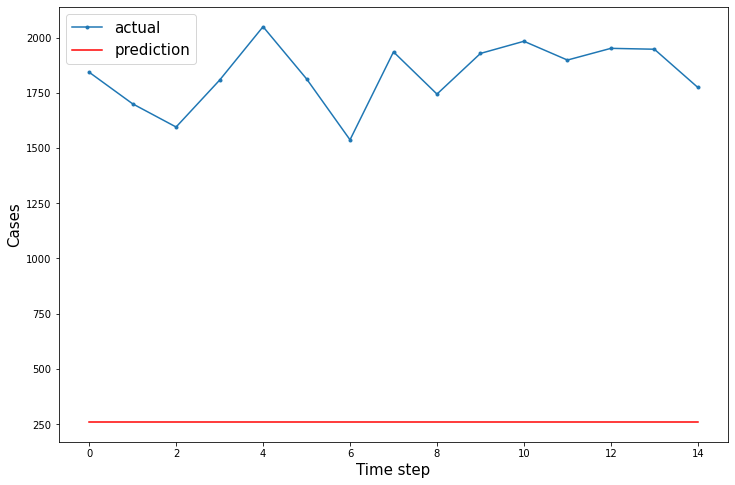

In [41]:
pyplot.figure(figsize=(12,8))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual")
pyplot.plot(aa, y_pred[:15], 'r', label="prediction")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# LogisticRegression

In [42]:
t1_start = process_time()  
LR = LogisticRegression(C=300 ,     random_state=None, solver='newton-cg'  ).fit(X_train, y_train)
t1_stop = process_time() 
LR_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         LR_process_time)  
y_pred = LR.predict(X_test)
# round(LR.score(X_testing,Y_testing), 4)

C:\Users\smr99\anaconda3\envs\pd\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Elapsed time: 29.84375 3.28125
Elapsed time during the whole program in seconds: 26.5625


C:\Users\smr99\anaconda3\envs\pd\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [43]:
LR_MSE  = mean_squared_error(y_test, y_pred, squared=True)
LR_RMSE  = mean_squared_error(y_test, y_pred, squared=False)

print("MSE:", LR_MSE)
print("RMSE:", LR_RMSE)

MSE: 1758198.625
RMSE: 1325.9708235854966


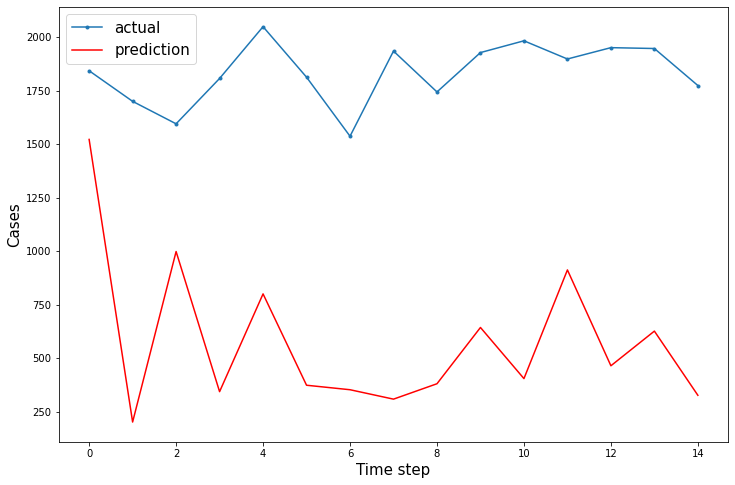

In [44]:
pyplot.figure(figsize=(12,8))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual")
pyplot.plot(aa, y_pred[:15], 'r', label="prediction")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# GradientBoostingRegressor

In [91]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [92]:
t1_start = process_time()
gbr = GradientBoostingRegressor(n_estimators=1000, random_state=0)
gbr.fit(X_train, y_train )
t1_stop = process_time() 
gbr_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         gbr_process_time)  

 

C:\Users\smr99\anaconda3\envs\pd\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Elapsed time: 146.703125 146.1875
Elapsed time during the whole program in seconds: 0.515625


In [93]:
y_pred = gbr.predict(X_test)

In [94]:
gbr_MSE  = mean_squared_error(y_test, y_pred, squared=True)
gbr_RMSE  = mean_squared_error(y_test, y_pred, squared=False)

print("MSE:", gbr_MSE)
print("RMSE:", gbr_RMSE)

MSE: 140158.58237651782
RMSE: 374.3775933152488


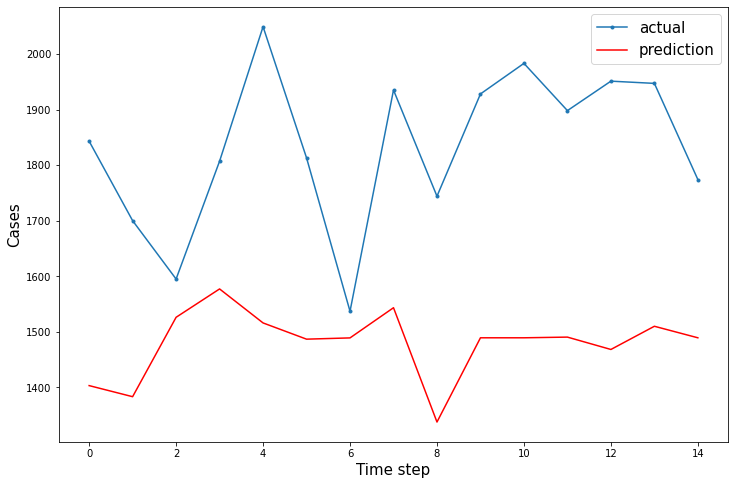

In [49]:
pyplot.figure(figsize=(12,8))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual")
pyplot.plot(aa, y_pred[:15], 'r', label="prediction")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# RandomForestRegressor

In [50]:
t1_start = process_time()
regr = RandomForestRegressor(n_estimators=1000, criterion='mae', max_depth=100 , random_state=0)
regr.fit(X_train, y_train)
t1_stop = process_time() 
regr_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         regr_process_time)  
 

C:\Users\smr99\anaconda3\envs\pd\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Elapsed time: 35.90625 31.40625
Elapsed time during the whole program in seconds: 4.5


In [51]:
y_pred = regr.predict(X_test)

In [52]:
regr_MSE  = mean_squared_error(y_test, y_pred, squared=True)
regr_RMSE  = mean_squared_error(y_test, y_pred, squared=False)

print("MSE:", regr_MSE)
print("RMSE:", regr_RMSE)

MSE: 193525.16868918753
RMSE: 439.9149562008406


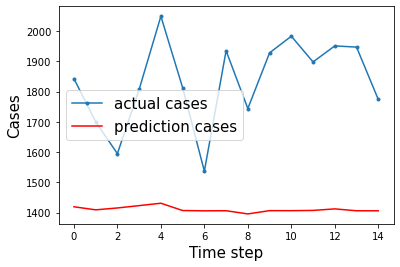

In [53]:
pyplot.figure(figsize=(6,4))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual cases")
pyplot.plot(aa, y_pred[:15], 'r', label="prediction cases")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

In [54]:
X

,load0,load1,load2,load3,load4,load5,load6
0,1,0,1,0,0,0,1
1,0,1,0,0,0,1,0
2,1,0,0,0,1,0,0
3,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
311,2049,1813,1537,1935,1744,1928,1983
312,1813,1537,1935,1744,1928,1983,1898
313,1537,1935,1744,1928,1983,1898,1951
314,1935,1744,1928,1983,1898,1951,1947


In [82]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.utils import to_categorical
from math import sqrt
from keras.layers import Bidirectional
from keras.layers import  GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

# LSTM

In [59]:
X_train_nn = X_train.values.reshape((X_train.shape[0],   X_train.shape[1],1))
X_test_nn  = X_test.values.reshape((X_test.shape[0],   X_test.shape[1],1))
print(X_train_nn.shape, y_train.shape, X_test_nn.shape, y_test.shape)
 

(300, 7, 1) (300, 1) (16, 7, 1) (16, 1)


In [60]:
# # normalizing input features
# scaler = MinMaxScaler(feature_range=(0, 1))
# y_test1 = scaler.fit_transform(y_test)
# y_test1 =pd.DataFrame(y_test1)

y_test1=y_test

In [61]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
y_train1 = scaler1.fit_transform(y_train)
y_train1 =pd.DataFrame(y_train1)

y_train1 =y_train1

In [62]:
def evaluate_model_lstm(trainX, trainy, testX, testy, epochs=10, batch_size=1,verbose=1):

    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(200, return_sequences=True,input_shape=(n_timesteps, n_features)))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(n_outputs ))
    model.compile(loss='mae', optimizer='adam' )
    # fit network
    model_history = model.fit(trainX, trainy, epochs=epochs,  batch_size=batch_size, verbose=verbose,  shuffle=False)
 
    return model,model_history

In [63]:
t1_start = process_time()
model_lstm, model_history  = evaluate_model_lstm(X_train_nn,y_train1,X_test_nn,y_test1)

t1_stop = process_time() 
model_lstm_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         model_lstm_process_time) 

Epoch 1/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0449
Epoch 2/10
300/300 [==============================] - 2s 6ms/step - loss: 0.0546
Epoch 3/10
300/300 [==============================] - 2s 6ms/step - loss: 0.0624
Epoch 4/10
300/300 [==============================] - 2s 6ms/step - loss: 0.0541
Epoch 5/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0664
Epoch 6/10
300/300 [==============================] - 2s 6ms/step - loss: 0.0635
Epoch 7/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0876
Epoch 8/10
300/300 [==============================] - 2s 7ms/step - loss: 0.1268
Epoch 9/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0686
Epoch 10/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0554
Elapsed time: 107.6875 36.171875
Elapsed time during the whole program in seconds: 71.515625


In [64]:
# pyplot.plot(model_history.history['loss'], label='LSTM train', color='red')
# pyplot.plot(model_history.history['val_loss'], label='LSTM test', color= 'green')

# pyplot.legend()
# pyplot.show()

In [65]:
yhat_test = model_lstm.predict(X_test_nn)


In [66]:
yhat_test11 = yhat_test

In [67]:
lstm_MSE  = mean_squared_error(y_test, yhat_test11, squared=True)
lstm_RMSE  = mean_squared_error(y_test, yhat_test11, squared=False)

print("MSE:", lstm_MSE)
print("RMSE:", lstm_RMSE)

MSE: 3360550.9033069685
RMSE: 1833.1805430199636


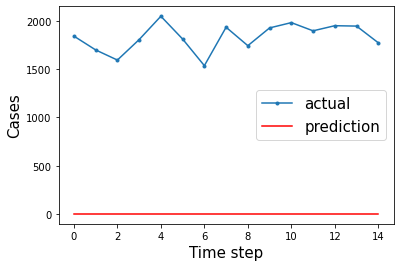

In [68]:
pyplot.figure(figsize=(6,4))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual")
pyplot.plot(aa, yhat_test11[:15], 'r', label="prediction")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# Conv1D_LSTM

In [72]:
def evaluate_model_Conv1D_LSTM(trainX, trainy, testX, testy,  epochs=10, batch_size=1,verbose=1):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(100, kernel_size=3, activation = 'relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(50))
    model.add(Dense(n_outputs ))
    model.compile(loss='mae', optimizer='adam' )
 
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

     
    return model

In [73]:
t1_start = process_time()
Conv1D_LSTM_model  = evaluate_model_Conv1D_LSTM(X_train_nn,y_train1,X_test_nn,y_test1)
t1_stop = process_time() 
Conv1D_LSTM_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                       Conv1D_LSTM_process_time) 

Epoch 1/10
300/300 [==============================] - 1s 4ms/step - loss: 0.1410
Epoch 2/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0923
Epoch 3/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0633
Epoch 4/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0605
Epoch 5/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0590
Epoch 6/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0538
Epoch 7/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0524
Epoch 8/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0521
Epoch 9/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0469
Epoch 10/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0521
Elapsed time: 142.125 109.03125
Elapsed time during the whole program in seconds: 33.09375


In [74]:
yhat_test2 = Conv1D_LSTM_model.predict(X_test_nn)

In [75]:
yhat_test3 = yhat_test2

In [76]:
Conv1D_LSTM_MSE  = mean_squared_error(y_test, yhat_test3, squared=True)
Conv1D_LSTM_RMSE  = mean_squared_error(y_test, yhat_test3, squared=False)

print("MSE:", Conv1D_LSTM_MSE)
print("RMSE:", Conv1D_LSTM_RMSE)

MSE: 3360322.9706192724
RMSE: 1833.1183733243395


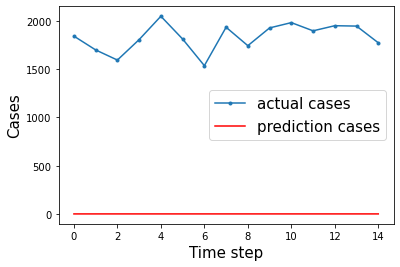

In [77]:
pyplot.figure(figsize=(6,4))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual cases")
pyplot.plot(aa, yhat_test3[:15], 'r', label="prediction cases")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# Conv1D

In [83]:

# fit and evaluate a model
def evaluate_model_Conv1D(trainX, trainy, testX, testy,  epochs=10, batch_size=1,verbose=1):
 
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=200, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
  
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(Dense(n_outputs ))
    model.compile(loss='mae', optimizer='adam' )
#     model.summary()
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

     
    return model

In [84]:
Conv1D_model  = evaluate_model_Conv1D(X_train_nn,y_train1,X_test_nn,y_test1)

Epoch 1/10
300/300 [==============================] - 0s 834us/step - loss: 6.7757
Epoch 2/10
300/300 [==============================] - 0s 575us/step - loss: 2.4355
Epoch 3/10
300/300 [==============================] - 0s 532us/step - loss: 2.1334
Epoch 4/10
300/300 [==============================] - 0s 572us/step - loss: 2.1084
Epoch 5/10
300/300 [==============================] - 0s 565us/step - loss: 2.6772
Epoch 6/10
300/300 [==============================] - 0s 535us/step - loss: 1.9141
Epoch 7/10
300/300 [==============================] - 0s 559us/step - loss: 1.7433
Epoch 8/10
300/300 [==============================] - 0s 554us/step - loss: 1.8763
Epoch 9/10
300/300 [==============================] - 0s 555us/step - loss: 1.5161
Epoch 10/10
300/300 [==============================] - 0s 611us/step - loss: 1.4920


In [85]:
t1_start = process_time()
yhat_test5 = Conv1D_model.predict(X_test_nn)
t1_stop = process_time() 
Conv1D_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                       Conv1D_LSTM_process_time) 

Elapsed time: 145.75 145.71875
Elapsed time during the whole program in seconds: 33.09375


In [86]:
yhat_test56 = yhat_test5

In [87]:
Conv1D_MSE  = mean_squared_error(y_test, yhat_test56, squared=True)
Conv1D_RMSE  = mean_squared_error(y_test, yhat_test56, squared=False)

print("MSE:", Conv1D_MSE)
print("RMSE:", Conv1D_RMSE)

MSE: 3323720.093994066
RMSE: 1823.1072634362647


 # Result Comparing

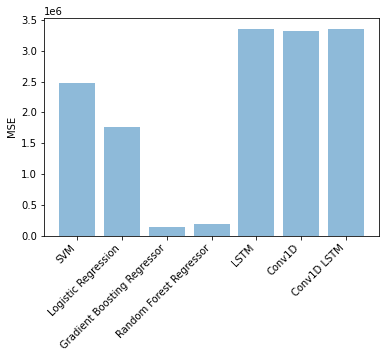

In [88]:
import matplotlib.pyplot as plt;  import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

objects = ('SVM', 'Logistic Regression', 'Gradient Boosting Regressor', 'Random Forest Regressor', 'LSTM', 'Conv1D', 'Conv1D LSTM' )
y_pos = np.arange(len(objects))
performance = [SVM_MSE, LR_MSE, gbr_MSE, regr_MSE, lstm_MSE, Conv1D_MSE, Conv1D_LSTM_MSE]
fig = plt.figure(figsize=(6, 4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('MSE')
 
plt.xticks(rotation=45, ha='right')
plt.show()
fig.savefig('images/MSE.pdf')

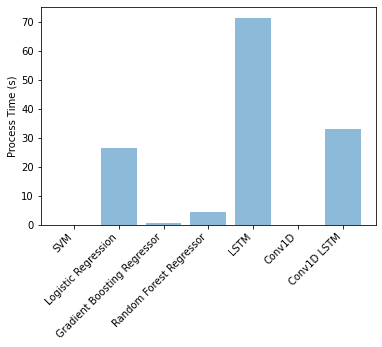

In [89]:
import matplotlib.pyplot as plt;  import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

objects = ('SVM', 'Logistic Regression', 'Gradient Boosting Regressor', 'Random Forest Regressor', 'LSTM', 'Conv1D', 'Conv1D LSTM' )
y_pos = np.arange(len(objects))
performance = [SVM_process_time, LR_process_time, gbr_process_time, regr_process_time, model_lstm_process_time, Conv1D_process_time, Conv1D_LSTM_process_time ]
fig = plt.figure(figsize=(6, 4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Process Time (s)')
 
plt.xticks(rotation=45, ha='right')
plt.show()
fig.savefig('images/RMSE.pdf')

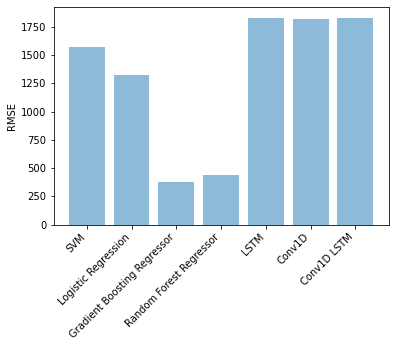

In [90]:
import matplotlib.pyplot as plt;  import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

objects = ('SVM', 'Logistic Regression', 'Gradient Boosting Regressor', 'Random Forest Regressor', 'LSTM', 'Conv1D', 'Conv1D LSTM' )
y_pos = np.arange(len(objects))
performance = [SVM_RMSE, LR_RMSE, gbr_RMSE, regr_RMSE, lstm_RMSE, Conv1D_RMSE, Conv1D_LSTM_RMSE ]
fig = plt.figure(figsize=(6, 4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
 
plt.xticks(rotation=45, ha='right')
plt.show()
fig.savefig('images/RMSE.pdf')